# Playground

The goal of this project is to generate medical reports from X-ray images. The images are in grayscale. We will work on a few so-called *image2text* models.

In [1]:
# @TODO: extract tags?

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("./code")

First the imports.

In [3]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader

import logging
logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

import spacy
#!python -m spacy download en_core_web_lg

import stanza
stanza.download("en")

from utils import *
from dataset import *
from plots import *

05:09:11 - INFO: Downloading default packages for language: en (English) ...
05:09:12 - INFO: File exists: /home/rasmus/stanza_resources/en/default.zip
05:09:17 - INFO: Finished downloading models and saved to /home/rasmus/stanza_resources.


In [4]:
def fix_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    np.random.seed(seed)

fix_seed()

## Load data

Let's load the metadata and the images.

In [5]:
REPORT_PATH = "./data/raw/reports"
IMAGE_PATH = "./data/raw/images"

In [6]:
metadata = load_reports(REPORT_PATH)
metadata.describe()

05:09:17 - INFO: found 3955 reports.


,image_name,comparison,indication,findings,impression
count,7470,6313,7311,6473,7418
unique,7470,394,2454,2553,1770
top,CXR82_IM-2350-3001.png,None.,Chest pain,The heart is normal in size. The mediastinum i...,No acute cardiopulmonary abnormality.
freq,1,1592,253,98,586


Notice, some of the text is censored by replacing words with "XXXX".

In [7]:
metadata.head()

,image_name,comparison,indication,findings,impression
0,CXR82_IM-2350-3001.png,Chest x-XXXX XXXX,PAIN IN THORACIC SPINE Pain started in leg are...,"No airspace disease, effusion or noncalcified ...",No acute cardiopulmonary abnormality.
1,CXR82_IM-2350-4001.png,Chest x-XXXX XXXX,PAIN IN THORACIC SPINE Pain started in leg are...,"No airspace disease, effusion or noncalcified ...",No acute cardiopulmonary abnormality.
2,CXR173_IM-0481-1001.png,None,Chest pain,Low lung volumes. Cardiomediastinal silhouette...,Low lung volumes. No acute cardiopulmonary fin...
3,CXR173_IM-0481-2001.png,None,Chest pain,Low lung volumes. Cardiomediastinal silhouette...,Low lung volumes. No acute cardiopulmonary fin...
4,CXR3676_IM-1829-0001-0001.png,Comparison is XXXX to XXXX examination dated X...,XXXX-year-old male with XXXX.,The cardiomediastinal silhouette appears irreg...,1. Redemonstration of diffuse bilateral pulmon...


The feature "findings" describes the radiologists observations. While "impression" is the final diagnosis / conclusion.
Let's define a report as the concatation of the findings and impression text.

In [31]:
def prepare_reports(metadata):
    reports = metadata["findings"].astype(str) + "\n" + metadata["impression"].astype(str)
    reports = reports.rename("report")
    return reports

In [33]:
reports = prepare_reports(metadata)
reports.head()
#pd.merge(metadata, report, left_index=True, right_index=True)

0    No airspace disease, effusion or noncalcified ...
1    No airspace disease, effusion or noncalcified ...
2    Low lung volumes. Cardiomediastinal silhouette...
3    Low lung volumes. Cardiomediastinal silhouette...
4    The cardiomediastinal silhouette appears irreg...
Name: report, dtype: object

Let's load the images. The images have been cropped such that the width and height are the same. Afterwards, the images have been scaled to 256x256. 

In [9]:
N = 1500
np_images = load_images(metadata[:N], IMAGE_PATH, resized=(256, 256))
images = torch.tensor(np_images)

There are images from two views: frontal and lateral. It may be worth to include this information in the model. However, since it hasn't already been annotated, we will ignore it for now.

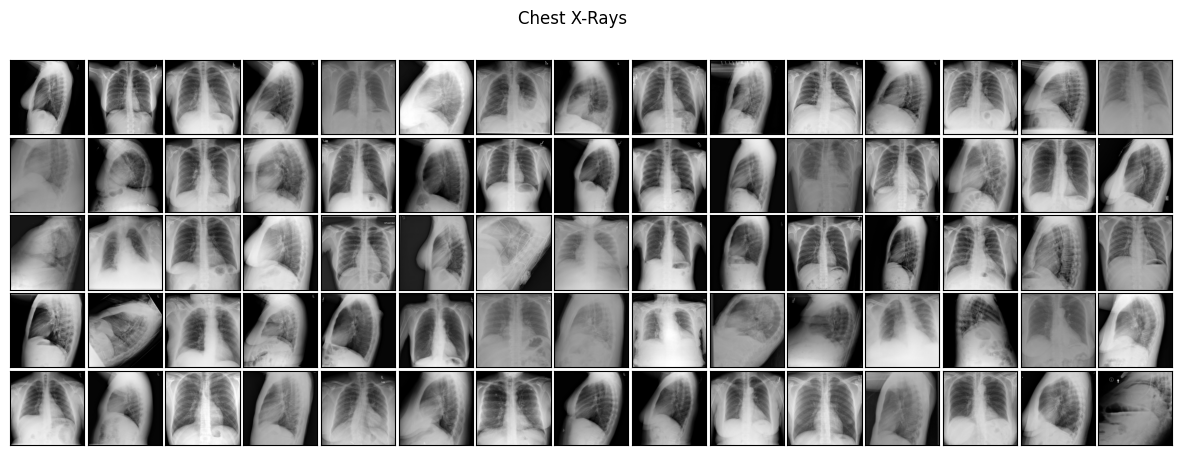

In [10]:
offset = 100
n_rows = 5
n_cols = 15

images_tiny = images[offset:offset+n_rows*n_cols]

plot_images_2d(images_tiny.reshape(n_rows, n_cols, *images_tiny.shape[1:]), "Chest X-Rays")

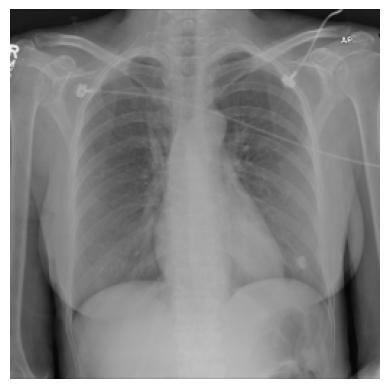

In [11]:
highlighted_sample = metadata.loc[metadata["image_name"] == "CXR21_IM-0729-1001-0001.png"]
highlighted_image = images[highlighted_sample.index]

plot_image(highlighted_image[0])

Time to plot a random X-ray image and its corresponding findings!

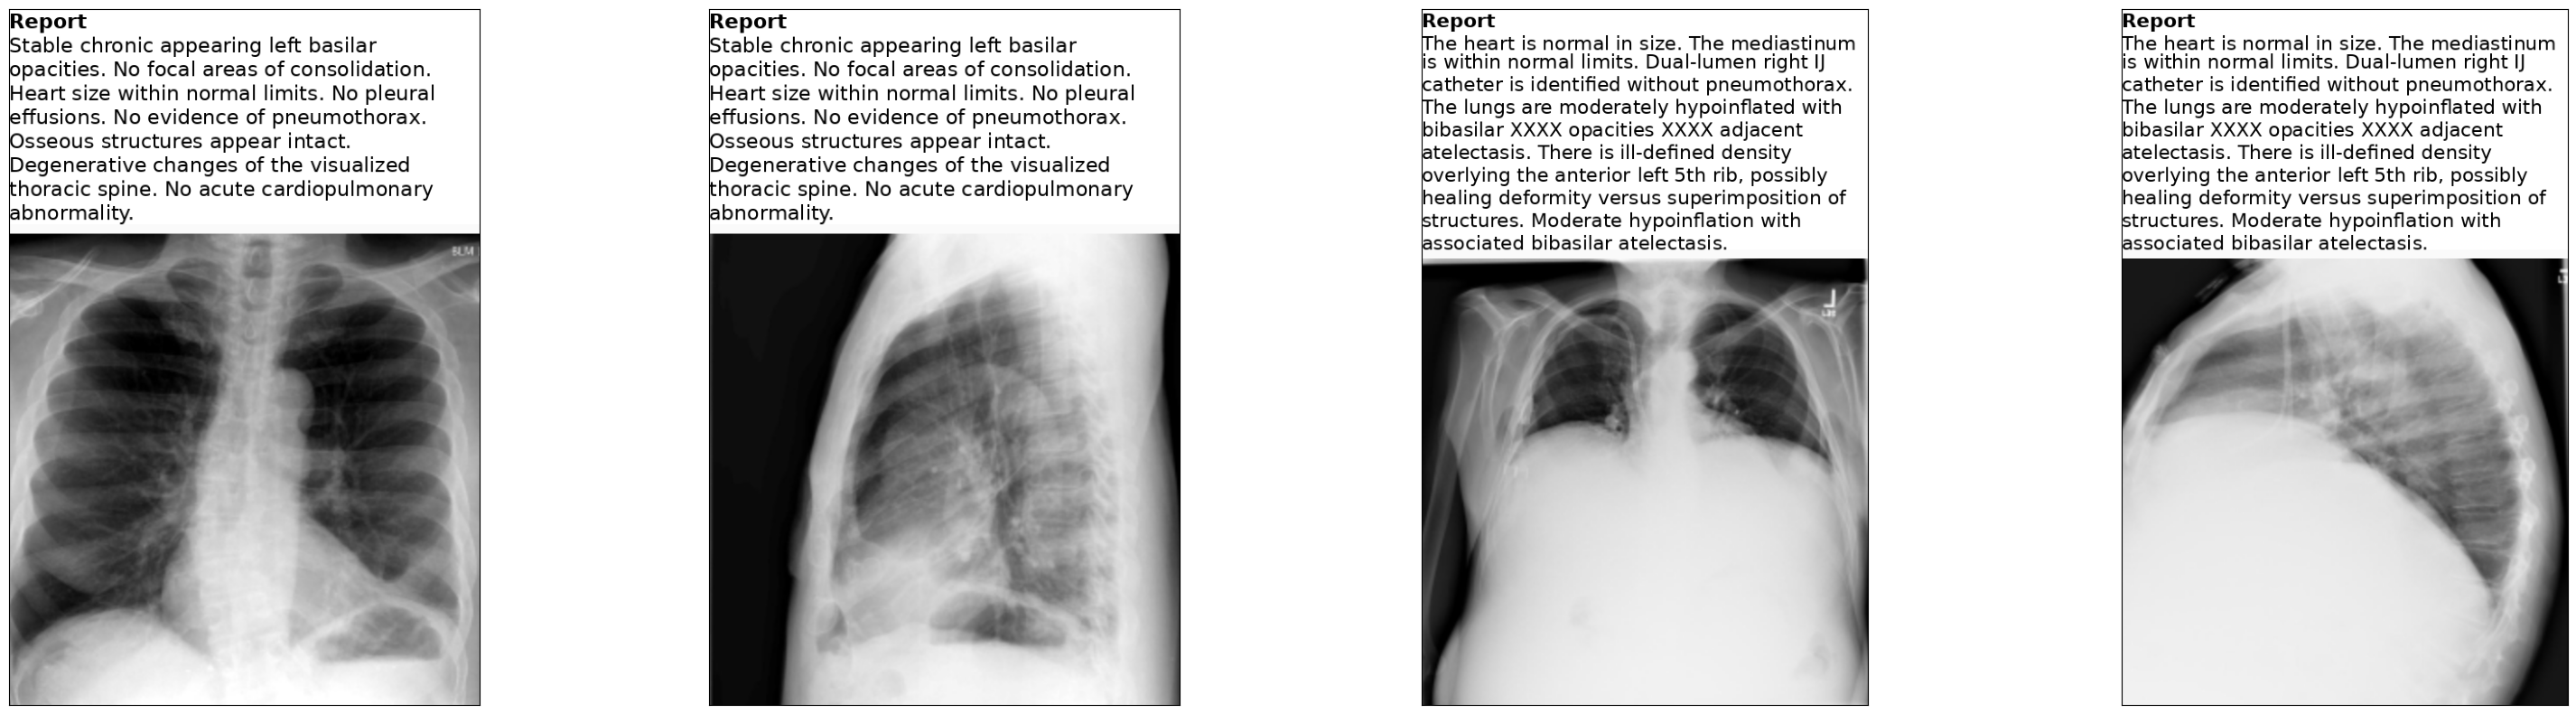

In [12]:
k = np.arange(4)+10

title = "Report"
#extracted_textbodies = metadata.iloc[k]["findings"]
extracted_textbodies = reports.iloc[k]
extracted_images = np_images[k]

plot_multiple_text_and_images(extracted_textbodies, title, extracted_images)

## Preprocessing

In [13]:
# reference: https://arxiv.org/pdf/1711.08195v3.pdf
# @TODO: tokenization, embedding
# @TODO: base model
# @TODO: transformer model
# @TODO: compare against GPT-4 (with images) if possible

### Images

Let's, normalize the images to the range [0, 1].

In [14]:
images = images.type(torch.float32) / 255.

In [15]:
images.shape

torch.Size([1500, 256, 256, 3])

### Text

In [16]:
def stanza_tokenizer():
    nlp = stanza.Pipeline(lang="en", processors="tokenize")
    return lambda text: [token.text for token in nlp(text).sentences[0].tokens]

In [17]:
def spacy_tokenizer():
    nlp = spacy.load('en_core_web_lg')
    return lambda text: [token.text for token in nlp(text)]

In [18]:
def tokenize(text, tokenizer):
    text = text.lower()
    tokens = tokenizer(text)
    return [token for token in tokens if token.isalpha()]

In [19]:
#tokenizer = spacy_tokenizer()
tokenizer = stanza_tokenizer()

tokenized_reports = reports.apply(lambda text : tokenize(text, tokenizer))

05:09:31 - INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


05:09:31 - INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

05:09:31 - INFO: Using device: cpu
05:09:31 - INFO: Loading: tokenize
05:09:31 - INFO: Done loading processors!


In [20]:
def build_vocabulary(tokens):
    return set(["[UNK]", "."]) | set(tokens)

In [21]:
def map_token_and_id(vocabulary):
    stabil_vocabulary = list(vocabulary)
    return {token: i for i, token in enumerate(stabil_vocabulary)}, {i: token for i, token in enumerate(stabil_vocabulary)}


def map_token_and_id_fn(vocabulary):
    token2id, id2token = map_token_and_id(vocabulary)
    return lambda token: token2id[token] if token in token2id else token2id["[UNK]"], lambda id: id2token[id]

In [22]:
vocabulary = build_vocabulary([token for tokens in tokenized_reports for token in tokens])
len(vocabulary)

850

In [23]:
token2id, id2token = map_token_and_id_fn(vocabulary)

## Models

In [24]:
class XRayDataset(Dataset):
    def __init__(self, images, reports, tokenizer):
        self.images = images
        self.reports = reports
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        report = self.reports.values[idx]

        report_length = len(report)
        report_ids = [token2id(token) for token in report]

        return image, report_ids, report_length

In [25]:
def report_collate_fn(input):
    images, reports, report_lengths = zip(*input)
    return images, reports, list(report_lengths)

In [26]:
train_split = .9
train_size = int(len(images) * train_split)

train_dataset = XRayDataset(images[:train_size], tokenized_reports[:train_size], tokenizer)
train_dl = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=report_collate_fn)

test_dataset = XRayDataset(images[train_size:], tokenized_reports[train_size:], tokenizer)
test_dl = DataLoader(test_dataset, batch_size=2, shuffle=True, collate_fn=report_collate_fn)

In [34]:

for xray, reports, report_lengths in train_dl:
    pass